# 1 Introduction
In this kernal I will dig into the data sources using seaborn for visualizations and pandas for aggregations, and at the end I will produce a submission file for Stage 1. The submission deadline for this contest is notourious for creeping up on the contestents, which happened to me last year when I missed the deadline and was not able to submit my predictions. One other important note about this competition is that this is not like the usaual March Madness brackets going around work where you pick your winners for each round, since you are providing the likelyhood of Team 1 winning for every possible match up if the team you pick looses you are stil in the game.  Also, since this is log loss, if you use 0 or 1 for one of you predictions and are wrong, your loss will go to infinity. 

# 2 Libraries
Kaggle starts you off with the numpy, pandas and os librarys for this kernal. I will also be using matplotlib and seaborn for plotting; sklearn functions for data processing and xgboost for the model. These are all pretty standard librarys for kaggle competitions, so nothing exiting here.

<img src="https://goo.gl/images/GNCCmP">

In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

# 3 Data Exploration
Wow, there are a lot of files available for this contest. It looks like everything is stored in .csv format, so it should be pretty easy to load with pandas `pd.read_csv` function. I used f-strings with list comprehensions below to print out the files provided in each of the folders.. 

In [2]:
ipfl = os.listdir("../input")
ipfls = [x for x in ipfl if '.' in x]
ipfds = [x for x in ipfl if '.' not in x]
print(f'Files in ../input: {ipfls}\n')
print(f'Folders in ../input: {ipfds}\n')
pbpfl = os.listdir("../input/playbyplay_2012")
print(f'Files in representative playbyplay folder: {pbpfl}\n')
dfs = os.listdir("../input/datafiles")
print(f'Files in datafiles folder: {dfs}\n')
mofl = os.listdir("../input/masseyordinals")
print(f'Files in masseyordinals folder: {mofl}')

Files in ../input: ['SampleSubmissionStage1.csv']

Folders in ../input: ['playbyplay_2012', 'playbyplay_2015', 'playbyplay_2018', 'playbyplay_2017', 'datafiles', 'playbyplay_2010', 'playbyplay_2013', 'playbyplay_2014', 'playbyplay_2016', 'masseyordinals', 'playbyplay_2011']

Files in representative playbyplay folder: ['Players_2012.csv', 'Events_2012.csv']

Files in datafiles folder: ['Seasons.csv', 'NCAATourneyDetailedResults.csv', 'Conferences.csv', 'NCAATourneySeedRoundSlots.csv', 'TeamConferences.csv', 'GameCities.csv', 'TeamSpellings.csv', 'NCAATourneySlots.csv', 'SecondaryTourneyTeams.csv', 'NCAATourneySeeds.csv', 'RegularSeasonCompactResults.csv', 'ConferenceTourneyGames.csv', 'TeamCoaches.csv', 'Teams.csv', 'NCAATourneyCompactResults.csv', 'Cities.csv', 'SecondaryTourneyCompactResults.csv', 'RegularSeasonDetailedResults.csv']

Files in masseyordinals folder: ['MasseyOrdinals.csv']


In this section I will go through most of the files give my thoughs on how the data can be used. I will also create a few visulizations for some of the more interesting and potentaily useful files. 

## 3.1 Sample Submission File 
First I like to find out what the submission will look like. I can do this by taking a look at the `SampleSubmissionStage1.csv` file. Since the comp is currently in Stage 1, the sample submission file includes all potential match ups for the 2014 through 2018 tournements. The 0.5 in Pred column cells indicates a 50/50 percent chance of either team winning; for the competition a zero means that team 1 wins and a 0 means that team 2 wins. The format of the ID column is year, team one (lower id), then team two (higher id) seperated by an underscore.

In [3]:
sub = pd.read_csv('../input/SampleSubmissionStage1.csv')
sub.tail(3)

,ID,Pred
11387,2018_1455_1460,0.5
11388,2018_1455_1462,0.5
11389,2018_1460_1462,0.5


## 3.2 Play by Play files
In each play by play folder there are two files; `Players_####.csv` and `Events_####.csv`. I took a look at the data in 2014 since the Stage 1 model building will be judged on models from this year. I took a look at the amount of data using the `pd.DataFrame.shape` attribute, then used the `pd.DataFrame.head()` method to look at the columns and a few values. I made a bar graph of events by winners and loosers to summarize the events data. There was not a whole lot to look at in the players file, so no graphs.

In [4]:
fl_2014 = '../input/playbyplay_2014/'
events = pd.read_csv(f'{fl_2014}Events_2014.csv')
players = pd.read_csv(f'{fl_2014}Players_2014.csv')
print(f'The events dataframe contains data from the Events_2014.csv file and is {events.shape[0]}'
      f' rows by {events.shape[1]} \ncolumns. The players dataframe contains the data from '
      f'the Players_2014.csv file and is {players.shape[0]} rows by {players.shape[1]} \nrows.')

The events dataframe contains data from the Events_2014.csv file and is 2613207 rows by 11 
columns. The players dataframe contains the data from the Players_2014.csv file and is 5406 rows by 4 
rows.


In [5]:
events.head(3)

,EventID,Season,DayNum,WTeamID,LTeamID,WPoints,LPoints,ElapsedSeconds,EventTeamID,EventPlayerID,EventType
0,10090542,2014,4,1102,1119,0,2,13,1119,621301,made2_jump
1,10090543,2014,4,1102,1119,0,0,32,1102,621053,turnover
2,10090544,2014,4,1102,1119,0,0,44,1119,621301,miss3_jump


In [6]:
players.head(3)

,PlayerID,Season,TeamID,PlayerName
0,621026,2014,1101,BLAKELEY_CHRIS
1,621027,2014,1101,COOKE_AUSTIN
2,621028,2014,1101,EDMONDSON_JULIAN


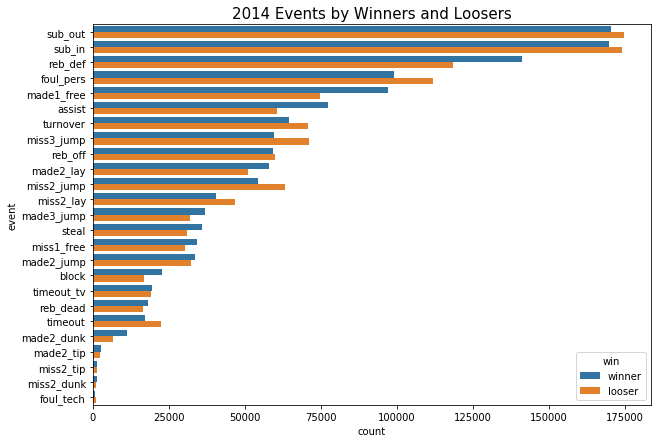

In [7]:
## The pandas Series.value_counts() method returns a pd.Sereis object with value counts for each unique
## value in a pd.Series. 

# seperate data into winners and loosers
winners = events[events['EventTeamID'] == events['WTeamID']] 
loosers = events[events['EventTeamID'] != events['WTeamID']]
val_wnrs = winners.EventType.value_counts().sort_values(ascending=True).to_frame()
val_lsrs = loosers.EventType.value_counts().sort_values(ascending=True).to_frame()

# stack the data for plotting with seaborn
totals = val_wnrs.merge(val_lsrs, right_index=True, left_index=True, suffixes=['_w', '_l']
                       ).sort_values(by='EventType_w', ascending=False)
totals.rename(columns={'EventType_w':'winner', 'EventType_l':'looser'}, inplace=True)
tts = totals.stack().reset_index()
tts.columns = ['event', 'win', 'count']

## plot data
plt.figure(figsize=(10,7))
sns.barplot(x='count', y='event', hue='win', data=tts, orient='h')
plt.title('2014 Events by Winners and Loosers', size=15)
plt.show()

## 3.3 Datafiles Files
There are a ton of files in the `datafiles` folder so I used a dictionary to store them all. I used list comprehensions to create the names and paths in order to load all of the files using pandas `pd.read_csv` function. The standard `pd.read_csv` worked for all of the files except for TeamSpellings. I will start with `RegularSeasonDetailedResults.csv` as this will likely be the most impactfull dat for an initial model and go from there. 

In [8]:
df_fdr = '../input/datafiles/'

In [9]:
files = os.listdir(df_fdr)
names = [x.split('.')[0] for x in files]
path_list = [f'{df_fdr}{x}' for x in files]
df_dict = {}
for num, name in enumerate(names):
    try:
        df_dict[name] = pd.read_csv(path_list[num])
    except:
        print(f'{name} did not load')

TeamSpellings did not load


In [10]:
print('Summary of files:\n___________________________')
for name, df in df_dict.items():
    print(f'{name}: {df.shape}')

Summary of files:
___________________________
Seasons: (35, 6)
NCAATourneyDetailedResults: (1048, 34)
Conferences: (51, 2)
NCAATourneySeedRoundSlots: (720, 5)
TeamConferences: (11241, 3)
GameCities: (49235, 6)
NCAATourneySlots: (2184, 4)
SecondaryTourneyTeams: (1568, 3)
NCAATourneySeeds: (2218, 3)
RegularSeasonCompactResults: (156089, 8)
ConferenceTourneyGames: (4861, 5)
TeamCoaches: (10994, 5)
Teams: (366, 4)
NCAATourneyCompactResults: (2184, 8)
Cities: (421, 3)
SecondaryTourneyCompactResults: (1551, 9)
RegularSeasonDetailedResults: (82041, 34)


The team seeds are likely the most important feature (and take the least processing) so I will use them for my model. I created a seed_num and seed_letter column since the letter is likely a categorical feature and the number would be considered continuous since the quantity matters.

In [11]:
seeds = df_dict.pop('NCAATourneySeeds') # This can only be run once.
seeds['seed_num'] = seeds.Seed.apply(lambda x: int(x[1:3]))
seeds['seed_letter'] = seeds.Seed.apply(lambda x: x[0])
seeds.head(3)

,Season,Seed,TeamID,seed_num,seed_letter
0,1985,W01,1207,1,W
1,1985,W02,1210,2,W
2,1985,W03,1228,3,W


The `NCAATourneyCompactResults` file contains the target data for model building. So I will do a little processing to make the lookups possible from the `seeds` data frame and to make the target consitant with what is in the `SampleSubmission` file. 

In [12]:
tcr = df_dict.pop('NCAATourneyCompactResults') # This can only be run once.
tcr['Team1'] = np.where((tcr.WTeamID < tcr.LTeamID), tcr.WTeamID, tcr.LTeamID)
tcr['Team2'] = np.where((tcr.WTeamID > tcr.LTeamID), tcr.WTeamID, tcr.LTeamID)
tcr['target'] = np.where((tcr['WTeamID'] < tcr['LTeamID']),1,0)
tcr.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Team1,Team2,target
0,1985,136,1116,63,1234,54,N,0,1116,1234,1
1,1985,136,1120,59,1345,58,N,0,1120,1345,1
2,1985,136,1207,68,1250,43,N,0,1207,1250,1


In [13]:
tcr_grouped = tcr.groupby('WTeamID')['Season'].count()
winners = tcr_grouped.sort_values(ascending=False).iloc[:20]

In [14]:
teams = df_dict.pop("Teams")
winners = winners.to_frame().merge(teams[['TeamID', 'TeamName']], how='left', left_index=True, right_on='TeamID')

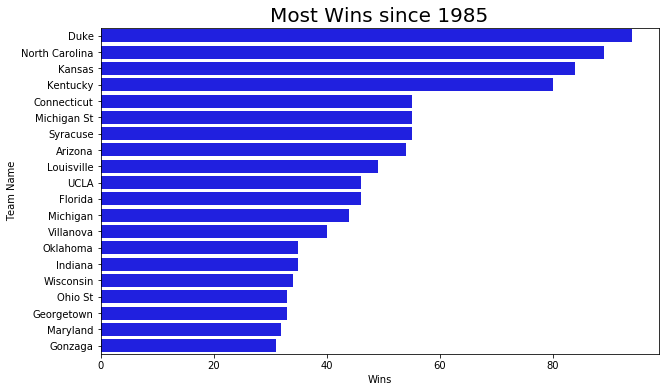

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(y=winners.TeamName, x=winners.Season, orient='h', color='b')
plt.xlabel('Wins')
plt.ylabel('Team Name')
plt.title('Most Wins since 1985', size=20)
plt.show()

# 4 Model Building
Now that I have identified and processed some usefull data, I will build a simple model. The first thing that I will need to do is set up the training and validation data using the `pd.DataFrame.merge()` method. Then I will seperate out a train and a test set, then I will train my model and finaly predict on the target test set.

In [16]:
def add_features(df, seeds=seeds):
    df = df.merge(seeds, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])
    df = df.merge(seeds, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID'], 
          suffixes=('Team1', 'Team2'))
    
    # encode the seed letters for both teams using the same LabelEncoder
    lb = LabelEncoder()
    df['seed_letterTeam1'] = lb.fit_transform(df['seed_letterTeam1'])
    df['seed_letterTeam2'] = lb.transform(df['seed_letterTeam2'])
    return df

In [17]:
tcr_ = add_features(tcr)

In [18]:
tcr_.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Team1,Team2,target,SeedTeam1,TeamIDTeam1,seed_numTeam1,seed_letterTeam1,SeedTeam2,TeamIDTeam2,seed_numTeam2,seed_letterTeam2
0,1985,136,1116,63,1234,54,N,0,1116,1234,1,X09,1116,9,1,X08,1234,8,1
1,1985,136,1120,59,1345,58,N,0,1120,1345,1,Z11,1120,11,3,Z06,1345,6,3
2,1985,136,1207,68,1250,43,N,0,1207,1250,1,W01,1207,1,0,W16,1250,16,0


In [19]:
features = ['seed_numTeam1', 'seed_letterTeam1', 'seed_numTeam2', 'seed_letterTeam2']
X = tcr_[features]
y = tcr_['target']

In [20]:
# split model for train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=7)

In [21]:
xgb = XGBClassifier() 
xgb.fit(X_train, y_train) # train
preds = xgb.predict_proba(X_test) # use predict_proba or a wrong prediction will result in infinity

This is where I will test the model to make sure it is doing better than the baseline.

In [22]:
pred_proba_df = pd.DataFrame(data=preds, columns=['win2', 'win1']) # win1 is target
pred_proba_df['baseline'] = .5

print(f"The log loss of this simple model is {log_loss(y_test, pred_proba_df['win1']):.4f} while the baseline"
      f" (.5 for every team) is {log_loss(y_test, pred_proba_df['baseline']):.4f}.")

The log loss of this simple model is 0.5715 while the baseline (.5 for every team) is 0.6931.


# 5 Submission file
I will use the `SampleSubmission` file to make my predictions, I just need to split up the columns to perform the lookups. I will also retrain the model on the full dataset for the predictions.

In [23]:
# source: https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns
sub['Season'], sub['Team1'], sub['Team2'] = sub['ID'].str.split('_').str
sub[['Season', 'Team1', 'Team2']] = sub[['Season', 'Team1', 'Team2']].apply(pd.to_numeric)

sub_ = add_features(sub)
sub_X = sub_[['seed_numTeam1', 'seed_letterTeam1', 'seed_numTeam2', 'seed_letterTeam2']]

xgb = XGBClassifier()
xgb.fit(X,y)
sub_preds = xgb.predict_proba(sub_X)

pred_proba_full_df = pd.DataFrame(data=sub_preds, columns=['win2', 'win1']) # win1 is target
sub['Pred'] = pred_proba_full_df['win1']
sub[['ID', 'Pred']].to_csv('submission.csv', index=False)